In [1]:
import numpy as np
from scipy import misc
import pprint as pp
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.models import load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam
from keras.losses import hinge, categorical_crossentropy
from keras import backend as Keras
from keras.callbacks import LearningRateScheduler, History
from keras.applications import ResNet50

from sklearn import metrics

Using TensorFlow backend.


In [2]:
import sys
sys.path.insert(0, '/home/albert/github/DenseNet/')
import densenet

### Train Network

In [3]:
CAFFE_ROOT = '/home/albert/caffe/'
img_dir = os.listdir(CAFFE_ROOT + 'data/market-1501/bounding_box_train')

In [4]:
train_files = {}
train_arr = []
labels = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        if not any(idt == l for l in labels):
            labels.append(idt)
            train_files[idt] = []
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_files[idt].append(path)
        train_arr.append([path, idt])

labels.sort()

train_img_paths = []
labels_one_hot = []

for f in img_dir:
    if f[-4:] == '.jpg':
        idt = int(f[0:f.index('_')])
        path = CAFFE_ROOT + 'data/market-1501/bounding_box_train/' + f
        train_img_paths.append(path)
        one_hot = np.zeros(751).tolist()
        one_hot[labels.index(idt)] = 1
        labels_one_hot.append(one_hot)

In [5]:
def output_batch_generator(files, labels_one_hot, batch_size=50):
    while True:
        batch = []
        l = []
        p_choice = np.random.choice(len(files), batch_size, replace=False)
        for p in p_choice:
            img = cv2.resize(misc.imread(files[p]).astype(np.float64), (224,224))
            batch.append(img.tolist())
            l.append(labels_one_hot[p])
        yield(np.array(batch), np.array(l))

In [6]:
def evaluate_rank(net, rank, all_embeddings, all_identities, test_iter=1000):
    correct = 0
    f_choice = np.random.choice(range(len(train_img_paths)), np.minimum(test_iter, len(train_img_paths)), replace=False)
    for f in f_choice:
        query_img = cv2.resize(misc.imread(train_img_paths[f]), (224,224))
        query_embedding = net.predict(query_img.reshape(1, 224, 224, 3))
        distance_vectors = np.squeeze(np.abs(all_embeddings - query_embedding))
#         print(distance_vectors)
        distance = np.sum(distance_vectors, axis=1)
        top_inds = distance.argsort()[:rank+1]
        output_classes = np.array(all_identities)[top_inds].astype(np.uint16)
        
#         pp.pprint(zip(distance[top_inds], np.array(all_identities)[top_inds].astype(np.uint16)))
#         print(int(all_identities[f]))
        
        i = 0
        for c in output_classes:
            if c == int(all_identities[f]):
                i += 1
        if i > 1:
            correct += 1
    return float(correct)/test_iter

In [7]:
def pos_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt = np.random.choice(labels, 1, replace=False)[0]
        sample_choice = np.random.choice(range(len(train_files[idt])), np.minimum(2, len(train_files[idt])), replace=False)
        pair = [cv2.resize(misc.imread(train_files[idt][p]), (224,224)).tolist() for p in sample_choice]
        yield(np.array(pair).astype(np.uint8))

def neg_pair_generator(train_files=train_files, labels=labels):
    while True:
        idt_choice = np.random.choice(labels, 2, replace=False)
        pair = []
        for idt in idt_choice:
            sample = np.random.choice(range(len(train_files[idt])), 1, replace=False)[0]
            pair.append(cv2.resize(misc.imread(train_files[idt][sample]), (224,224)).tolist())
        yield(np.array(pair).astype(np.uint8))

def l2(x1, x2):
    l2 = np.sqrt(np.sum(np.power(x1 - x2, 2)))
    return l2

def evaluate_dist(model, generator, n_pairs=1000):
    distances = []
    for t in range(n_pairs):
        pair = generator.next()   
        predict = [model.predict(pair[i].reshape(1,224,224,3)) for i in range(2)]
#         print predict
        dist = l2(predict[0], predict[1])
        distances.append(dist)
    return distances

In [8]:
# https://keras.io/applications/#fine-tune-inceptionv3-on-a-new-set-of-classes
i = 0
# for epochs in range(10, 20, 10):
image_dim = (224, 224, 3)
# base_model = densenet.DenseNetImageNet121(input_shape=(224,224,3))
base_model = ResNet50(weights='imagenet')

In [9]:
base_model.outputs = [base_model.layers[-2].output]
base_model.layers[-1].outbound_nodes = []

x = base_model.outputs[0]
x = Dense(1024)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
predictions = Dense(751)(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss=categorical_crossentropy, optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              metrics=['acc'])

In [10]:
for layer in model.layers:
    layer.trainable = True

In [11]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

In [12]:
def step_decay(epoch):
    initial_lr = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lr * np.power(drop,  
           np.floor((1+epoch)**2/(epochs_drop*epochs_drop)))
    return lrate

In [13]:
def step_decay_cont(epoch, init_epoch=0, init_lr=0.0001):
    drop = 0.5
    epochs_drop = 10.0
    lrate = init_lr * np.power(drop,  
           np.floor((1 + epoch + init_epoch)**2/(epochs_drop*epochs_drop)))
    return lrate

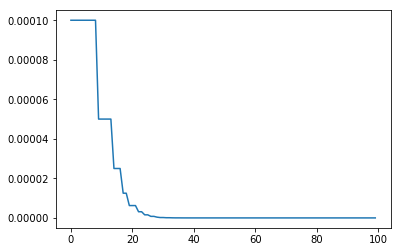

In [14]:
plt.plot(np.arange(100), step_decay(np.arange(100)))

In [15]:
history = History()

Epoch 1/25
100/100 [==============================] - 78s - loss: 9.7155 - acc: 0.0050    
Epoch 2/25
100/100 [==============================] - 77s - loss: 9.8432 - acc: 0.0058    
Epoch 3/25
100/100 [==============================] - 77s - loss: 9.6844 - acc: 0.0058    
Epoch 4/25
100/100 [==============================] - 77s - loss: 9.9846 - acc: 0.0075    
Epoch 5/25
100/100 [==============================] - 77s - loss: 10.0301 - acc: 0.0058    
Epoch 6/25
100/100 [==============================] - 77s - loss: 10.1156 - acc: 0.0033    
Epoch 7/25
100/100 [==============================] - 77s - loss: 9.6927 - acc: 0.0017    
Epoch 8/25
100/100 [==============================] - 77s - loss: 9.7835 - acc: 0.0033    
Epoch 9/25
100/100 [==============================] - 77s - loss: 10.0059 - acc: 0.0025   
Epoch 10/25
100/100 [==============================] - 77s - loss: 9.7262 - acc: 0.0042    
Epoch 11/25
100/100 [==============================] - 77s - loss: 9.8916 - acc: 0.0067

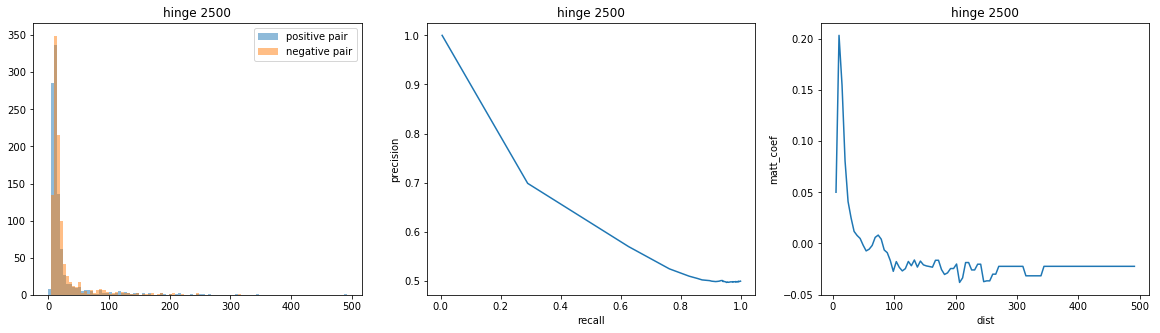

rank5 [0.265, 0.271, 0.277]
rank20 [0.409, 0.4, 0.399]
Epoch 1/25
100/100 [==============================] - 75s - loss: 9.6037 - acc: 0.0000e+00    
Epoch 2/25
100/100 [==============================] - 74s - loss: 9.2446 - acc: 0.0050    
Epoch 3/25
100/100 [==============================] - 74s - loss: 9.2109 - acc: 0.0042    
Epoch 4/25
100/100 [==============================] - 74s - loss: 9.2441 - acc: 0.0042    
Epoch 5/25
100/100 [==============================] - 74s - loss: 9.6496 - acc: 8.3333e-04    
Epoch 6/25
100/100 [==============================] - 74s - loss: 8.9064 - acc: 0.0058    
Epoch 7/25
100/100 [==============================] - 74s - loss: 9.1932 - acc: 0.0042    
Epoch 8/25
100/100 [==============================] - 73s - loss: 9.3482 - acc: 0.0025    
Epoch 9/25
100/100 [==============================] - 74s - loss: 9.5999 - acc: 0.0050    
Epoch 10/25
100/100 [==============================] - 74s - loss: 9.3755 - acc: 0.0050    
Epoch 11/25
100/100 [=====

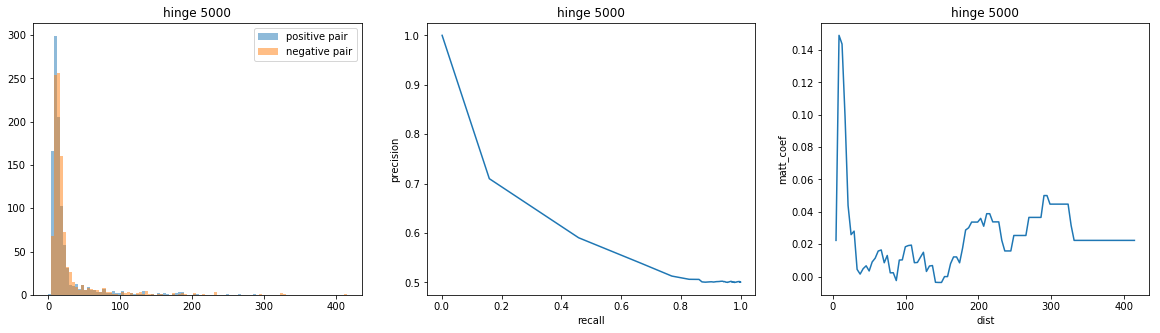

rank5 [0.27, 0.267, 0.262]
rank20 [0.424, 0.395, 0.405]
Epoch 1/25
100/100 [==============================] - 75s - loss: 9.1248 - acc: 0.0017    
Epoch 2/25
100/100 [==============================] - 74s - loss: 9.5802 - acc: 0.0058    
Epoch 3/25
100/100 [==============================] - 75s - loss: 9.0767 - acc: 0.0058    
Epoch 4/25
100/100 [==============================] - 74s - loss: 9.1978 - acc: 0.0042    
Epoch 5/25
100/100 [==============================] - 74s - loss: 8.9704 - acc: 0.0042    
Epoch 6/25
100/100 [==============================] - 75s - loss: 9.6514 - acc: 8.3333e-04    
Epoch 7/25
100/100 [==============================] - 75s - loss: 9.3307 - acc: 0.0058    
Epoch 8/25
100/100 [==============================] - 74s - loss: 9.1645 - acc: 0.0050    
Epoch 9/25
100/100 [==============================] - 75s - loss: 9.0191 - acc: 0.0017    
Epoch 10/25
100/100 [==============================] - 74s - loss: 9.0145 - acc: 0.0025    
Epoch 11/25
100/100 [========

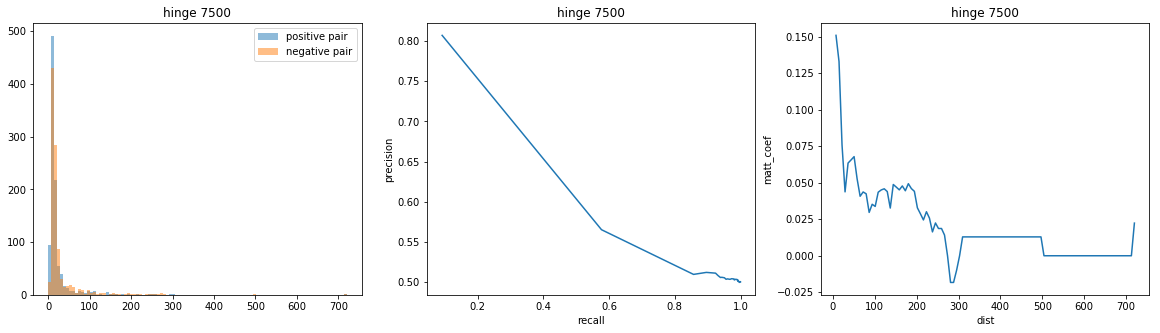

rank5 [0.279, 0.285, 0.27]
rank20 [0.413, 0.406, 0.389]
Epoch 1/25
100/100 [==============================] - 75s - loss: 9.3751 - acc: 0.0050    
Epoch 2/25
100/100 [==============================] - 74s - loss: 9.1236 - acc: 0.0050    
Epoch 3/25
100/100 [==============================] - 75s - loss: 9.1997 - acc: 0.0033    
Epoch 4/25
100/100 [==============================] - 75s - loss: 8.8705 - acc: 0.0025    
Epoch 5/25
100/100 [==============================] - 75s - loss: 9.0919 - acc: 0.0042    
Epoch 6/25
100/100 [==============================] - 75s - loss: 9.2004 - acc: 0.0050    
Epoch 7/25
100/100 [==============================] - 74s - loss: 9.2764 - acc: 0.0025    
Epoch 8/25
100/100 [==============================] - 75s - loss: 9.3252 - acc: 0.0033    
Epoch 9/25
100/100 [==============================] - 75s - loss: 9.2610 - acc: 8.3333e-04    
Epoch 10/25
100/100 [==============================] - 75s - loss: 9.0476 - acc: 0.0050    
Epoch 11/25
100/100 [========

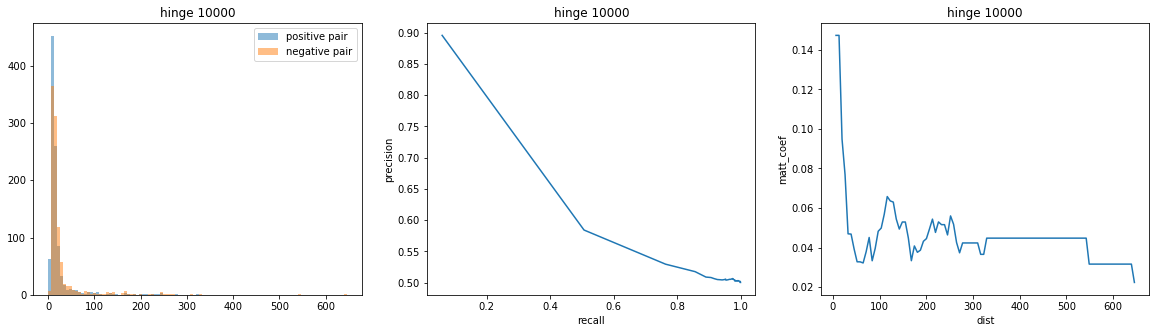

rank5 [0.261, 0.26, 0.268]
rank20 [0.405, 0.418, 0.378]


In [16]:
score = {
    'rank5' : {},
    'rank20' : {},
    'pos_distance' : {},
    'neg_distance' : {},
    'precision' : {},
    'recall' : {},
    'matt_coef' : {},
    'loss' : [],
    'file_name' : {}
}

pos_generator = pos_pair_generator()
neg_generator = neg_pair_generator()

epochs = 25
steps_per_epoch = 100

file_root = 'resnet_cross_entropy_224x224_'

for era in range(1,5):
    iterations = era * steps_per_epoch * epochs
    
    def step_decay_cont(epoch, init_epoch=epochs*(era - 1), init_lr=0.0001):
        drop = 0.5
        epochs_drop = 10.0
        lrate = init_lr * np.power(drop,  
               np.floor((1 + epoch + init_epoch)**2/(epochs_drop*epochs_drop)))
        return lrate
    
    lrate = LearningRateScheduler(step_decay_cont)
    
    model.fit_generator(output_batch_generator(train_img_paths, labels_one_hot, batch_size=12), 
                     steps_per_epoch=steps_per_epoch, 
                     epochs=epochs,
                        callbacks=[lrate, history])
    
    file_name = file_root + str(iterations) + '.h5'
    score['file_name'][iterations] = file_name
    model.save('/home/albert/github/tensorflow/models/%s' % file_name)
    
    layer_name = 'dense_2'
    embedding_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    
    all_embeddings = []
    all_identities = []
    for f in range(len(train_img_paths)):
        img = cv2.resize(misc.imread(train_img_paths[f]), (224,224))
        predict = embedding_model.predict(img.reshape(1,224,224,3))
        all_embeddings.append(predict)
        all_identities.append(labels_one_hot[f].index(1))

    for rank in [5,20]:
        rank_arr = []
        for x in range(3):
            rank_score = evaluate_rank(embedding_model, rank, all_embeddings, all_identities, test_iter=1000)
            rank_arr.append(rank_score)
        score['rank%d' % rank][iterations] = rank_arr
    
    pos_distance = evaluate_dist(embedding_model, pos_generator)
    score['pos_distance'][iterations] = pos_distance
    
    neg_distance = evaluate_dist(embedding_model, neg_generator)
    score['neg_distance'][iterations] = neg_distance
    
    score['precision'][iterations] = []
    score['recall'][iterations] = []
    score['matt_coef'][iterations] = []
    
    for thresh in np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:]:
        true = np.ones(len(pos_distance)).tolist() + np.zeros(len(neg_distance)).tolist()
        pred_pos = [int(d < thresh) for d in pos_distance]
        pred_neg = [int(d < thresh) for d in neg_distance]
        pred = pred_pos + pred_neg

        score['precision'][iterations].append(metrics.precision_score(true, pred))
        score['recall'][iterations].append(metrics.recall_score(true, pred))
        score['matt_coef'][iterations].append(metrics.matthews_corrcoef(true, pred))
    
    score['loss'] += history.history['loss']
    
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    bins = np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 100)
    plt.hist(score['pos_distance'][iterations], bins, alpha=0.5, label='positive pair')
    plt.hist(score['neg_distance'][iterations], bins, alpha=0.5, label='negative pair')
    plt.legend(loc='upper right')
    plt.title('hinge %d' % iterations)

    plt.subplot(1,3,2)
    plt.plot(score['recall'][iterations], score['precision'][iterations])
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.title('hinge %d' % iterations)

    plt.subplot(1,3,3)
    plt.plot(np.linspace(0, np.max(np.array(pos_distance + neg_distance)), 101)[1:], 
             score['matt_coef'][iterations])
    plt.xlabel('dist')
    plt.ylabel('matt_coef')
    plt.title('hinge %d' % iterations)
    plt.show()
    
    print 'rank5', score['rank5'][iterations]
    print 'rank20', score['rank20'][iterations]

In [17]:
np.savez('/home/albert/github/tensorflow/models/densenet_cross_entropy_score.npz', score)